In [4]:
!pip -q install opencv-python-headless numpy matplotlib

In [5]:
from google.colab import files
uploaded = files.upload()

Saving 08fd33_4.mp4 to 08fd33_4.mp4


In [6]:
import os
print(list(uploaded.keys()))
print("Current dir:", os.getcwd())
print("Files:", os.listdir("."))

['08fd33_4.mp4']
Current dir: /content
Files: ['.config', '08fd33_4.mp4', 'yolov8s.pt', 'sample_data']


Read ok: True
Frame shape: (1080, 1920, 3)


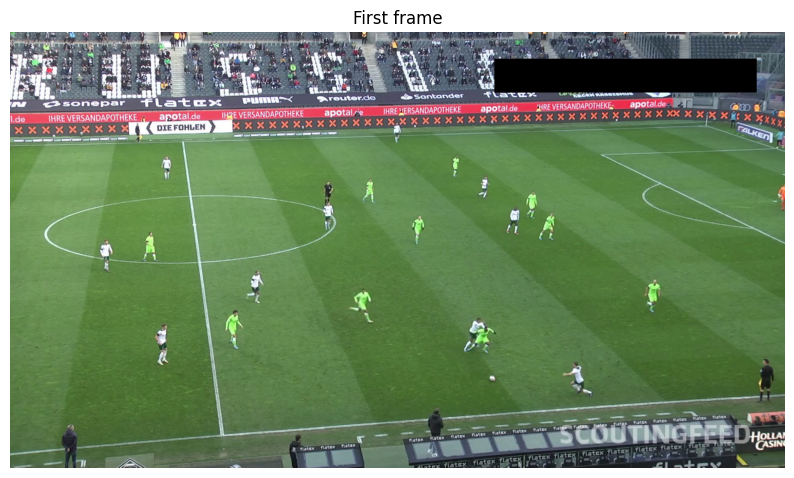

In [7]:
import cv2
import matplotlib.pyplot as plt

video_path = "08fd33_4.mp4"

cap = cv2.VideoCapture(video_path)
ok, frame = cap.read()
cap.release()

print("Read ok:", ok)
print("Frame shape:", None if frame is None else frame.shape)

if ok:

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(frame_rgb)
    plt.axis("off")
    plt.title("First frame")
    plt.show()


In [8]:
!pip -q install ultralytics

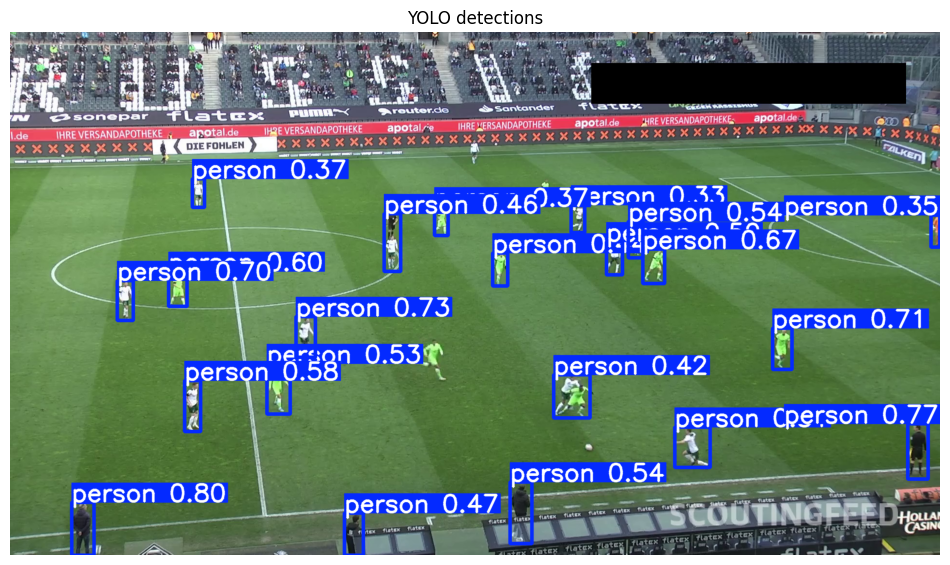

In [9]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("yolov8n.pt")

results = model.predict(source=frame, conf=0.25, iou=0.5, verbose=False)

annotated = results[0].plot()
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,7))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title("YOLO detections")
plt.show()


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

def clamp(v, lo, hi):
    return max(lo, min(hi, v))

def jersey_feature_hsv(frame_bgr, x1, y1, x2, y2):

    h, w = frame_bgr.shape[:2]
    x1 = clamp(x1, 0, w-1); x2 = clamp(x2, 0, w-1)
    y1 = clamp(y1, 0, h-1); y2 = clamp(y2, 0, h-1)

    if x2 <= x1 or y2 <= y1:
        return None

    crop = frame_bgr[y1:y2, x1:x2]
    if crop.size == 0:
        return None


    ch = crop.shape[0]
    y_top = int(0.25 * ch)
    y_bot = int(0.65 * ch)
    patch = crop[y_top:y_bot, :]

    if patch.size == 0:
        return None

    hsv = cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)

    H = hsv[:,:,0].astype(np.float32)
    S = hsv[:,:,1].astype(np.float32)
    V = hsv[:,:,2].astype(np.float32)


    grass = (H >= 35) & (H <= 85) & (S > 40) & (V > 40)
    keep = ~grass

    if keep.sum() < 50:

        h_mean, s_mean, v_mean = H.mean(), S.mean(), V.mean()
    else:
        h_mean, s_mean, v_mean = H[keep].mean(), S[keep].mean(), V[keep].mean()

    return np.array([h_mean, s_mean, v_mean], dtype=np.float32)


r = results[0]
names = r.names
boxes = r.boxes

person_id = [k for k,v in names.items() if v == "person"][0]

detections = []
features = []

for b in boxes:
    cls = int(b.cls.item())
    conf = float(b.conf.item())
    if cls != person_id or conf < 0.35:
        continue

    x1, y1, x2, y2 = b.xyxy[0].cpu().numpy()
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)


    Hf, Wf = frame.shape[:2]
    if y1 < int(0.25 * Hf):
        continue
    if y2 > int(0.92 * Hf):
        continue

    feat = jersey_feature_hsv(frame, x1, y1, x2, y2)
    if feat is None:
        continue

    h_mean, s_mean, v_mean = feat

    if v_mean < 80 and s_mean < 80:
        continue

    detections.append((x1,y1,x2,y2,conf))
    features.append(feat)

features = np.array(features)
print("Candidates for team clustering:", len(detections))


Candidates for team clustering: 15


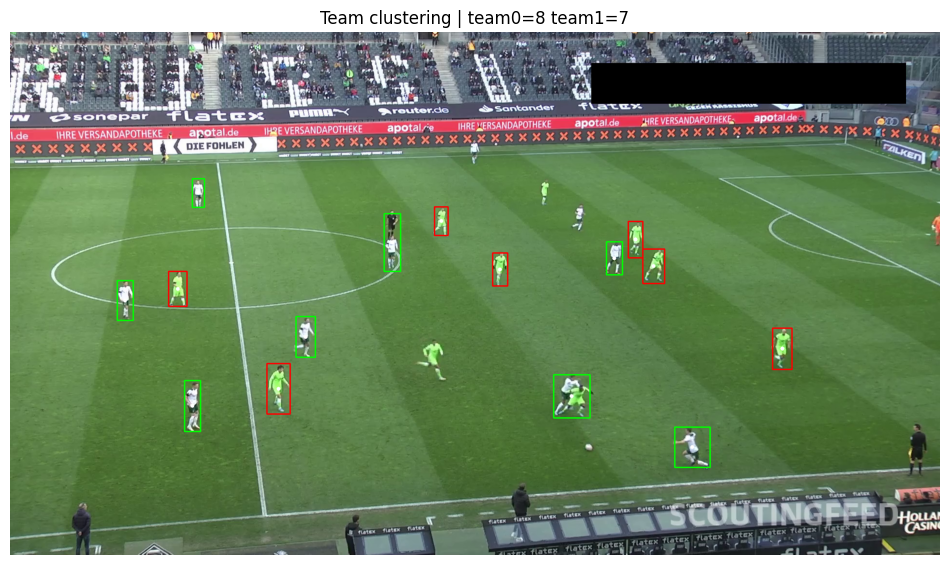

In [11]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(features)

vis = frame.copy()

team_counts = {0: 0, 1: 0}
for (x1,y1,x2,y2,conf), lab in zip(detections, labels):
    team_counts[int(lab)] += 1
    color = (0,255,0) if lab == 0 else (0,0,255)
    cv2.rectangle(vis, (x1,y1), (x2,y2), color, 2)

    cx, cy = (x1+x2)//2, (y1+y2)//2
    cv2.circle(vis, (cx,cy), 4, (255,255,255), -1)

vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,7))
plt.imshow(vis_rgb)
plt.axis("off")
plt.title(f"Team clustering | team0={team_counts[0]} team1={team_counts[1]}")
plt.show()


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.cluster import KMeans


model = YOLO("yolov8n.pt")


conf_th = 0.25
iou_th = 0.5
stride = 5
max_frames = 300

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Nu pot citi video-ul.")

H, W = first_frame.shape[:2]

# Heatmaps
heat_team0 = np.zeros((H, W), dtype=np.float32)
heat_team1 = np.zeros((H, W), dtype=np.float32)


y_top = int(0.25 * H)
y_bot = int(0.92 * H)



def is_dark_ref(feat):
    h_mean, s_mean, v_mean = feat
    return (v_mean < 80 and s_mean < 80)

processed = 0
frame_idx = 0



GREEN_H = 60.0

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    # YOLO inference
    res = model.predict(source=frame, conf=conf_th, iou=iou_th, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k,v in names.items() if v == "person"][0]

    detections = []
    feats = []

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.35:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)


        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue


        if is_dark_ref(feat):
            continue

        detections.append((x1, y1b, x2, y2b))
        feats.append(feat)

    if len(detections) >= 6:
        feats_np = np.array(feats, dtype=np.float32)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(feats_np)


        c0_h = kmeans.cluster_centers_[0][0]
        c1_h = kmeans.cluster_centers_[1][0]
        green_label = 0 if abs(c0_h - GREEN_H) < abs(c1_h - GREEN_H) else 1

        for (x1, y1b, x2, y2b), lab in zip(detections, labels):
            cx = int((x1 + x2) / 2)
            cy = int((y1b + y2b) / 2)


            if lab == green_label:
                heat_team1[cy, cx] += 1.0
            else:
                heat_team0[cy, cx] += 1.0

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()

print("Processed frames:", processed)
print("Heat sums:", heat_team0.sum(), heat_team1.sum())


Processed frames: 150
Heat sums: 776.0 594.0


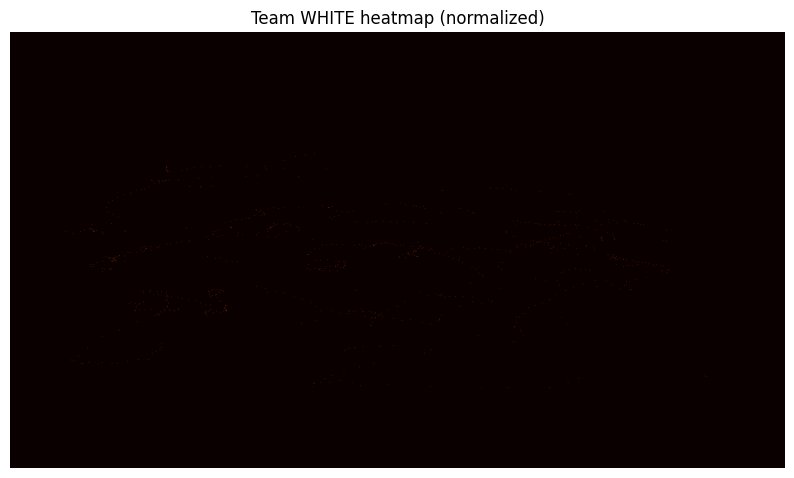

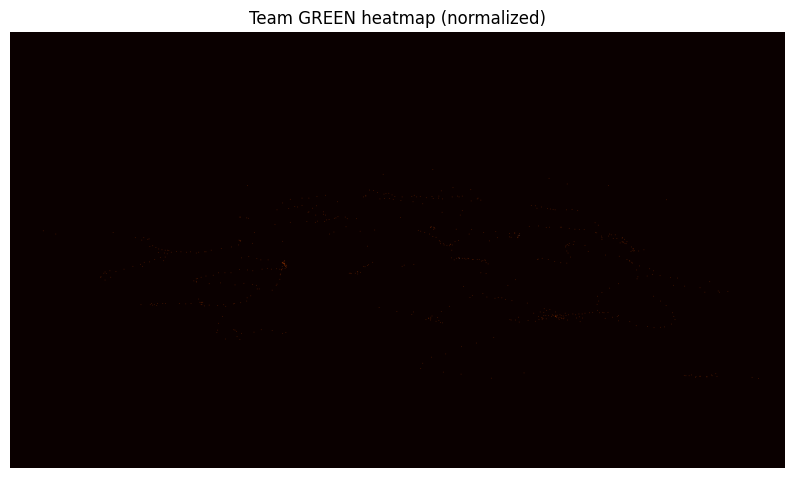

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def normalize_heatmap(hm):
    return hm / (hm.max() + 1e-6)

hm0 = normalize_heatmap(heat_team0)
hm1 = normalize_heatmap(heat_team1)

plt.figure(figsize=(10,6))
plt.imshow(hm0, cmap="hot")
plt.axis("off")
plt.title("Team WHITE heatmap (normalized)")
plt.show()

plt.figure(figsize=(10,6))
plt.imshow(hm1, cmap="hot")
plt.axis("off")
plt.title("Team GREEN heatmap (normalized)")
plt.show()


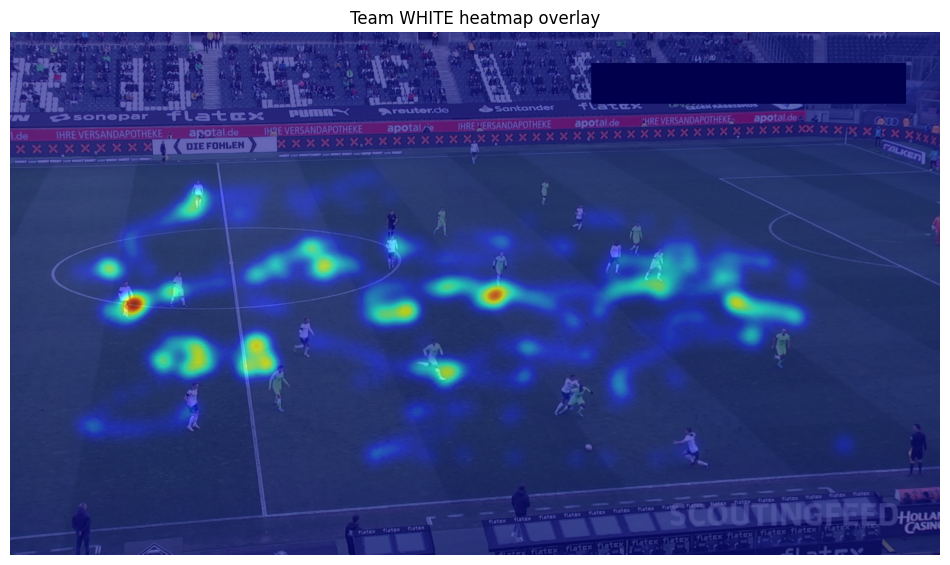

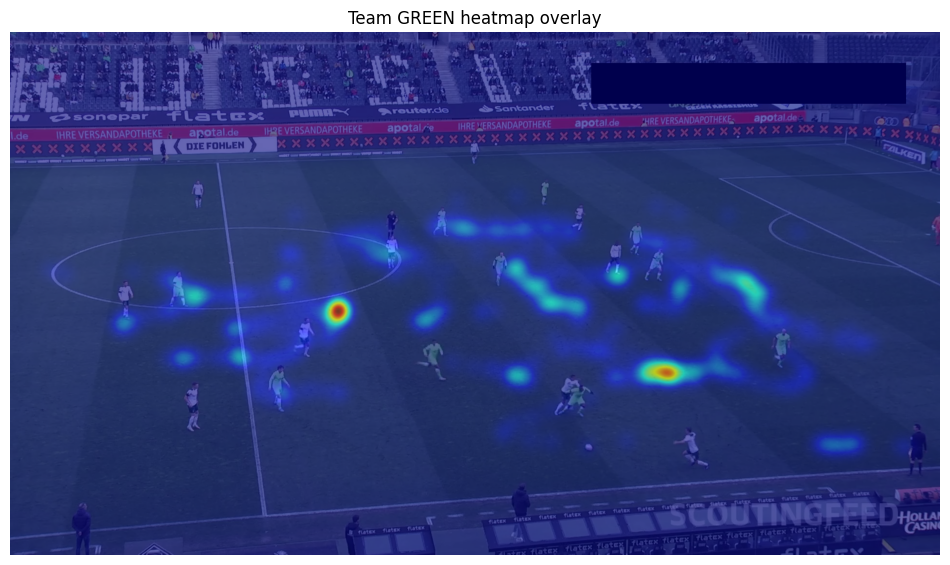

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def smooth_heatmap(hm, ksize=101):
    return cv2.GaussianBlur(hm, (ksize, ksize), 0)

def overlay_heatmap(frame, hm, alpha=0.6):
    hm_norm = hm / (hm.max() + 1e-6)
    hm_color = cv2.applyColorMap((hm_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 1 - alpha, hm_color, alpha, 0)
    return overlay

heat0_smooth = smooth_heatmap(heat_team0)
heat1_smooth = smooth_heatmap(heat_team1)

overlay0 = overlay_heatmap(first_frame, heat0_smooth)
overlay1 = overlay_heatmap(first_frame, heat1_smooth)

plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(overlay0, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Team WHITE heatmap overlay")
plt.show()

plt.figure(figsize=(12,7))
plt.imshow(cv2.cvtColor(overlay1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Team GREEN heatmap overlay")
plt.show()


In [15]:
import cv2
import numpy as np
from ultralytics import YOLO
from sklearn.cluster import KMeans

model = YOLO("yolov8n.pt")

conf_th = 0.25
iou_th = 0.5
stride = 5
max_frames = 200

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "team_white_heatmap_video.mp4"
writer = cv2.VideoWriter(out_path, fourcc, 25, (W, H))

heat_white = np.zeros((H, W), dtype=np.float32)

def is_dark_kit(feat):
    h_mean, s_mean, v_mean = feat
    return (v_mean < 80 and s_mean < 80)

GREEN_H = 60.0

processed = 0
frame_idx = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k, v in names.items() if v == "person"][0]

    detections = []
    feats = []

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.35:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        if is_dark_kit(feat):
            continue

        detections.append((x1, y1b, x2, y2b))
        feats.append(feat)

    if len(detections) >= 6:
        feats_np = np.array(feats, dtype=np.float32)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(feats_np)

        c0_h = kmeans.cluster_centers_[0][0]
        c1_h = kmeans.cluster_centers_[1][0]
        green_label = 0 if abs(c0_h - GREEN_H) < abs(c1_h - GREEN_H) else 1

        for (x1, y1b, x2, y2b), lab in zip(detections, labels):
            cx = int((x1 + x2) / 2)
            cy = int((y1b + y2b) / 2)

            if lab != green_label:
                heat_white[cy, cx] += 1.0

    heat_smooth = cv2.GaussianBlur(heat_white, (101, 101), 0)
    hm_norm = heat_smooth / (heat_smooth.max() + 1e-6)
    hm_color = cv2.applyColorMap((hm_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame, 0.4, hm_color, 0.6, 0)

    writer.write(overlay)

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()
writer.release()

print("Saved:", out_path)
print("Processed frames:", processed)


Saved: team_white_heatmap_video.mp4
Processed frames: 150


In [16]:
from google.colab import files
files.download("team_white_heatmap_video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import cv2
import numpy as np
from ultralytics import YOLO
from sklearn.cluster import KMeans

model = YOLO("yolov8n.pt")

conf_th = 0.25
iou_th = 0.5
stride = 5
max_frames = 250

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")

out_white = "team_white_heatmap_video.mp4"
out_green = "team_green_heatmap_video.mp4"
out_combined = "combined_heatmap_video.mp4"

writer_white = cv2.VideoWriter(out_white, fourcc, 25, (W, H))
writer_green = cv2.VideoWriter(out_green, fourcc, 25, (W, H))
writer_combined = cv2.VideoWriter(out_combined, fourcc, 25, (W, H))

heat_white = np.zeros((H, W), dtype=np.float32)
heat_green = np.zeros((H, W), dtype=np.float32)

def is_dark_kit(feat):
    h_mean, s_mean, v_mean = feat
    return (v_mean < 80 and s_mean < 80)

GREEN_H = 60.0

processed = 0
frame_idx = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k, v in names.items() if v == "person"][0]

    detections = []
    feats = []

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.35:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        if is_dark_kit(feat):
            continue

        detections.append((x1, y1b, x2, y2b))
        feats.append(feat)

    if len(detections) >= 6:
        feats_np = np.array(feats, dtype=np.float32)
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(feats_np)

        c0_h = kmeans.cluster_centers_[0][0]
        c1_h = kmeans.cluster_centers_[1][0]
        green_label = 0 if abs(c0_h - GREEN_H) < abs(c1_h - GREEN_H) else 1

        for (x1, y1b, x2, y2b), lab in zip(detections, labels):
            cx = int((x1 + x2) / 2)
            cy = int((y1b + y2b) / 2)

            if lab == green_label:
                heat_green[cy, cx] += 1.0
            else:
                heat_white[cy, cx] += 1.0

    hs_w = cv2.GaussianBlur(heat_white, (101, 101), 0)
    hs_g = cv2.GaussianBlur(heat_green, (101, 101), 0)

    w_norm = hs_w / (hs_w.max() + 1e-6)
    g_norm = hs_g / (hs_g.max() + 1e-6)

    w_color = cv2.applyColorMap((w_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    g_color = cv2.applyColorMap((g_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

    overlay_w = cv2.addWeighted(frame, 0.4, w_color, 0.6, 0)
    overlay_g = cv2.addWeighted(frame, 0.4, g_color, 0.6, 0)

    combined_color = cv2.addWeighted(w_color, 0.5, g_color, 0.5, 0)
    overlay_c = cv2.addWeighted(frame, 0.45, combined_color, 0.55, 0)

    writer_white.write(overlay_w)
    writer_green.write(overlay_g)
    writer_combined.write(overlay_c)

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()
writer_white.release()
writer_green.release()
writer_combined.release()

print("Saved:", out_white, out_green, out_combined)
print("Processed frames:", processed)

KeyboardInterrupt: 

In [ ]:
from google.colab import files
files.download("team_white_heatmap_video.mp4")
files.download("team_green_heatmap_video.mp4")
files.download("combined_heatmap_video.mp4")

In [ ]:
import cv2
import numpy as np

def smooth(hm, k=101):
    return cv2.GaussianBlur(hm, (k, k), 0)

def to_colormap(hm):
    hm_norm = hm / (hm.max() + 1e-6)
    return cv2.applyColorMap((hm_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

hs_w = smooth(heat_white if "heat_white" in globals() else heat_team0)
hs_g = smooth(heat_green if "heat_green" in globals() else heat_team1)

w_color = to_colormap(hs_w)
g_color = to_colormap(hs_g)

combined_color = cv2.addWeighted(w_color, 0.5, g_color, 0.5, 0)

overlay_w = cv2.addWeighted(first_frame, 0.4, w_color, 0.6, 0)
overlay_g = cv2.addWeighted(first_frame, 0.4, g_color, 0.6, 0)
overlay_c = cv2.addWeighted(first_frame, 0.45, combined_color, 0.55, 0)

cv2.imwrite("team_white_heatmap_overlay.png", overlay_w)
cv2.imwrite("team_green_heatmap_overlay.png", overlay_g)
cv2.imwrite("combined_heatmap_overlay.png", overlay_c)

cv2.imwrite("team_white_heatmap_colormap.png", w_color)
cv2.imwrite("team_green_heatmap_colormap.png", g_color)
cv2.imwrite("combined_heatmap_colormap.png", combined_color)

print("Saved PNGs.")

In [ ]:
from google.colab import files
files.download("team_white_heatmap_overlay.png")
files.download("team_green_heatmap_overlay.png")
files.download("combined_heatmap_overlay.png")
files.download("team_white_heatmap_colormap.png")
files.download("team_green_heatmap_colormap.png")
files.download("combined_heatmap_colormap.png")

In [18]:
import numpy as np
import pandas as pd

hm_w = heat_white if "heat_white" in globals() else heat_team0
hm_g = heat_green if "heat_green" in globals() else heat_team1

def heatmap_metrics(hm):
    total = float(hm.sum())
    peak = float(hm.max())
    nonzero = int((hm > 0).sum())
    p95 = float(np.percentile(hm[hm > 0], 95)) if nonzero > 0 else 0.0
    return total, peak, nonzero, p95

w_total, w_peak, w_nz, w_p95 = heatmap_metrics(hm_w)
g_total, g_peak, g_nz, g_p95 = heatmap_metrics(hm_g)

df = pd.DataFrame([
    {"Team": "WHITE", "Total hits": w_total, "Peak value": w_peak, "Non-zero pixels": w_nz, "95th percentile": w_p95},
    {"Team": "GREEN", "Total hits": g_total, "Peak value": g_peak, "Non-zero pixels": g_nz, "95th percentile": g_p95},
])

df

Team  Total hits  Peak value  Non-zero pixels  95th percentile
0  WHITE       297.0         1.0              297              1.0
1  GREEN       257.0         2.0              254              1.0

In [ ]:
!pip -q install ultralytics

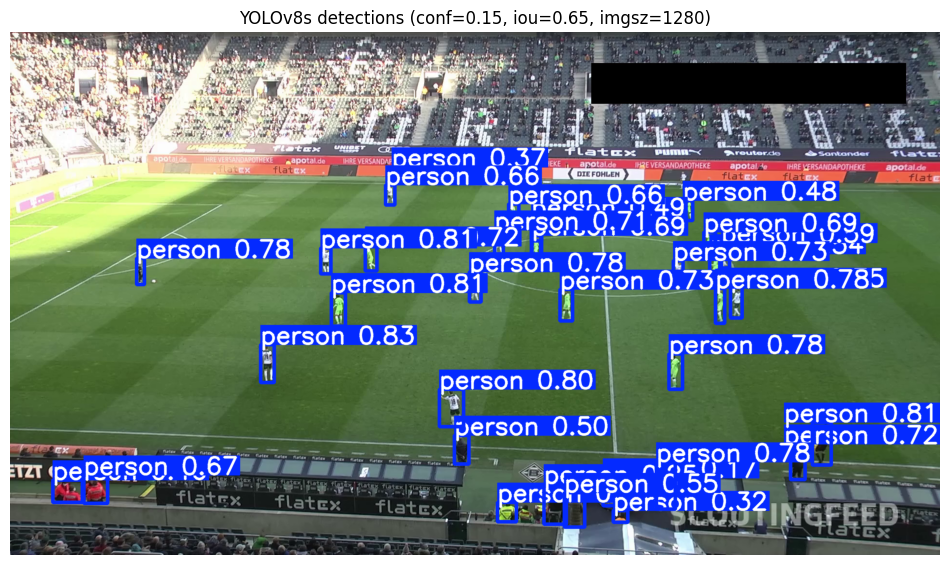

Detected persons: 34


In [19]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("yolov8s.pt")

res = model.predict(source=frame, conf=0.15, iou=0.65, imgsz=1280, verbose=False)[0]

annotated = res.plot()
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,7))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title("YOLOv8s detections (conf=0.15, iou=0.65, imgsz=1280)")
plt.show()

names = res.names
person_id = [k for k,v in names.items() if v == "person"][0]
person_count = int((res.boxes.cls.cpu().numpy() == person_id).sum())
print("Detected persons:", person_count)

Read ok: True
Frame shape: (1080, 1920, 3)


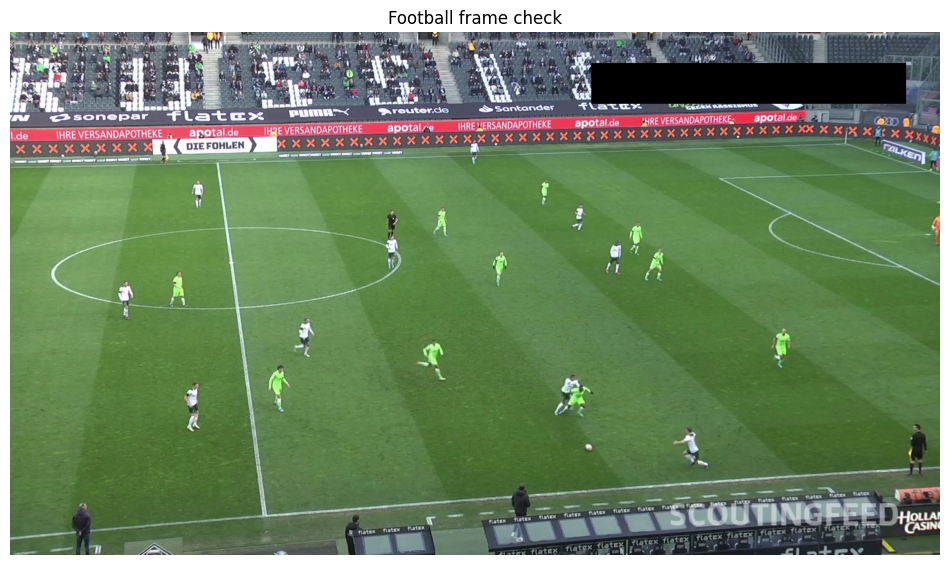

In [20]:
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(video_path)
ok, frame = cap.read()
cap.release()

print("Read ok:", ok)
print("Frame shape:", None if frame is None else frame.shape)

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,7))
plt.imshow(frame_rgb)
plt.axis("off")
plt.title("Football frame check")
plt.show()


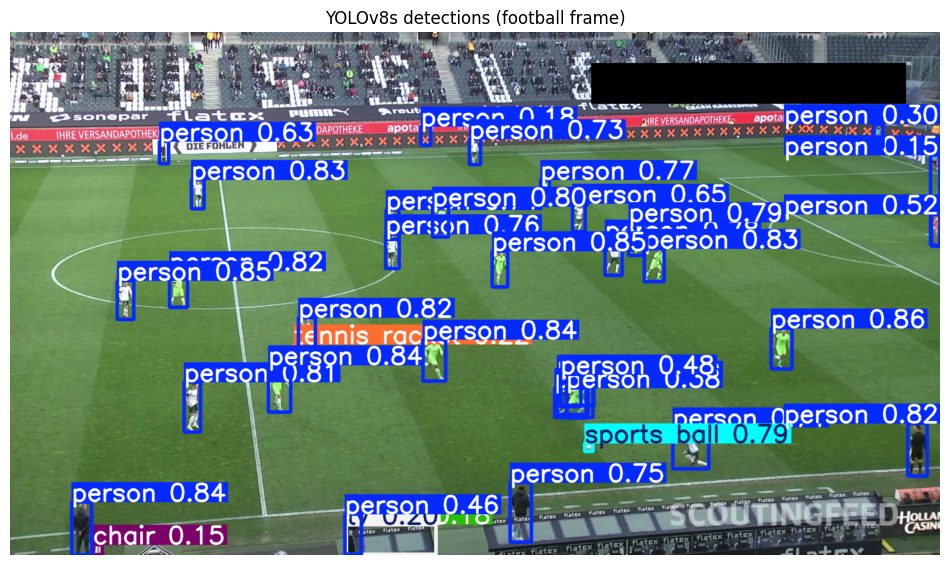

Detected persons: 34


In [21]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("yolov8s.pt")

res = model.predict(source=frame, conf=0.15, iou=0.65, imgsz=1280, verbose=False)[0]

annotated = res.plot()
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,7))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title("YOLOv8s detections (football frame)")
plt.show()

names = res.names
person_id = [k for k,v in names.items() if v == "person"][0]
person_count = int((res.boxes.cls.cpu().numpy() == person_id).sum())
print("Detected persons:", person_count)


In [22]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

conf_th = 0.15
iou_th = 0.65
stride = 5
bootstrap_frames = 60

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

all_features = []

frame_idx = 0
processed = 0

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k,v in names.items() if v == "person"][0]

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.3:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        h_mean, s_mean, v_mean = feat
        if v_mean < 80 and s_mean < 80:
            continue

        all_features.append(feat)

    processed += 1
    if processed >= bootstrap_frames:
        break

    frame_idx += 1

cap.release()

all_features = np.array(all_features)
kmeans_global = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_global.fit(all_features)

centers = kmeans_global.cluster_centers_
print("Global team centers:", centers)

Global team centers: [[     59.373      118.07      164.18]
 [     89.969      31.109      194.25]]


In [23]:
import numpy as np
import cv2
from ultralytics import YOLO
from sklearn.cluster import KMeans

model = YOLO("yolov8s.pt")

conf_th = 0.15
iou_th = 0.65
stride = 5
bootstrap_frames = 60

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

all_features = []

frame_idx = 0
processed = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k, v in names.items() if v == "person"][0]

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.3:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        h_mean, s_mean, v_mean = feat
        if v_mean < 80 and s_mean < 80:
            continue

        all_features.append(feat)

    processed += 1
    if processed >= bootstrap_frames:
        break

    frame_idx += 1

cap.release()

all_features = np.array(all_features, dtype=np.float64)

kmeans_global = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_global.fit(all_features)

print("Bootstrap features:", all_features.shape)
print("Global team centers:", kmeans_global.cluster_centers_)

Bootstrap features: (1344, 3)
Global team centers: [[     59.236      118.14      164.36]
 [     90.075       31.04      194.49]]


In [24]:
import numpy as np
import cv2
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

conf_th = 0.15
iou_th = 0.65
stride = 5
max_frames = 300

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

heat_white = np.zeros((H, W), dtype=np.float32)
heat_green = np.zeros((H, W), dtype=np.float32)

centers = kmeans_global.cluster_centers_
GREEN_H = 60.0
green_label = 0 if abs(centers[0][0] - GREEN_H) < abs(centers[1][0] - GREEN_H) else 1

frame_idx = 0
processed = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k, v in names.items() if v == "person"][0]

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.3:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        h_mean, s_mean, v_mean = feat
        if v_mean < 80 and s_mean < 80:
            continue

        label = kmeans_global.predict(np.array([feat], dtype=np.float64))[0]

        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)

        if label == green_label:
            heat_green[cy, cx] += 1.0
        else:
            heat_white[cy, cx] += 1.0

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()

print("Processed frames:", processed)
print("Heat sums:", float(heat_white.sum()), float(heat_green.sum()))

Processed frames: 150
Heat sums: 1575.0 1788.0


In [25]:
import cv2
import numpy as np

hs_w = cv2.GaussianBlur(heat_white, (101, 101), 0)
hs_g = cv2.GaussianBlur(heat_green, (101, 101), 0)

w_norm = hs_w / (hs_w.max() + 1e-6)
g_norm = hs_g / (hs_g.max() + 1e-6)

w_color = cv2.applyColorMap((w_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
g_color = cv2.applyColorMap((g_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

combined_color = cv2.addWeighted(w_color, 0.5, g_color, 0.5, 0)

overlay_w = cv2.addWeighted(first_frame, 0.4, w_color, 0.6, 0)
overlay_g = cv2.addWeighted(first_frame, 0.4, g_color, 0.6, 0)
overlay_c = cv2.addWeighted(first_frame, 0.45, combined_color, 0.55, 0)

cv2.imwrite("v2_team_white_heatmap_overlay.png", overlay_w)
cv2.imwrite("v2_team_green_heatmap_overlay.png", overlay_g)
cv2.imwrite("v2_combined_heatmap_overlay.png", overlay_c)

print("Saved: v2_team_white_heatmap_overlay.png, v2_team_green_heatmap_overlay.png, v2_combined_heatmap_overlay.png")


Saved: v2_team_white_heatmap_overlay.png, v2_team_green_heatmap_overlay.png, v2_combined_heatmap_overlay.png


In [26]:
import cv2
import numpy as np
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

conf_th = 0.15
iou_th = 0.65
stride = 5
max_frames = 300

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

heat_white_v = np.zeros((H, W), dtype=np.float32)
heat_green_v = np.zeros((H, W), dtype=np.float32)

centers = kmeans_global.cluster_centers_
GREEN_H = 60.0
green_label = 0 if abs(centers[0][0] - GREEN_H) < abs(centers[1][0] - GREEN_H) else 1

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out_path = "v2_combined_heatmap_video.mp4"
writer = cv2.VideoWriter(out_path, fourcc, 25, (W, H))

frame_idx = 0
processed = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    person_id = [k for k, v in names.items() if v == "person"][0]

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.3:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        h_mean, s_mean, v_mean = feat
        if v_mean < 80 and s_mean < 80:
            continue

        label = kmeans_global.predict(np.array([feat], dtype=np.float64))[0]

        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)

        if label == green_label:
            heat_green_v[cy, cx] += 1.0
        else:
            heat_white_v[cy, cx] += 1.0

    hs_w = cv2.GaussianBlur(heat_white_v, (101, 101), 0)
    hs_g = cv2.GaussianBlur(heat_green_v, (101, 101), 0)

    w_norm = hs_w / (hs_w.max() + 1e-6)
    g_norm = hs_g / (hs_g.max() + 1e-6)

    w_color = cv2.applyColorMap((w_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    g_color = cv2.applyColorMap((g_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

    combined_color = cv2.addWeighted(w_color, 0.5, g_color, 0.5, 0)
    overlay = cv2.addWeighted(frame, 0.45, combined_color, 0.55, 0)

    writer.write(overlay)

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()
writer.release()

print("Saved:", out_path)
print("Processed frames:", processed)

Saved: v2_combined_heatmap_video.mp4
Processed frames: 150


In [27]:
from google.colab import files
files.download("v2_team_white_heatmap_overlay.png")
files.download("v2_team_green_heatmap_overlay.png")
files.download("v2_combined_heatmap_overlay.png")
files.download("v2_combined_heatmap_video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
import numpy as np
import cv2
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

conf_th = 0.15
iou_th = 0.65
stride = 5
max_frames = 300

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

centers = kmeans_global.cluster_centers_
GREEN_H = 60.0
green_label = 0 if abs(centers[0][0] - GREEN_H) < abs(centers[1][0] - GREEN_H) else 1

heat_white = np.zeros((H, W), dtype=np.float32)
heat_green = np.zeros((H, W), dtype=np.float32)

heat_white_poss = np.zeros((H, W), dtype=np.float32)
heat_green_poss = np.zeros((H, W), dtype=np.float32)

poss_white = 0
poss_green = 0
poss_none = 0
ball_found = 0

frame_idx = 0
processed = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes

    person_id = [k for k, v in names.items() if v == "person"][0]
    ball_id = [k for k, v in names.items() if v == "sports ball"][0]

    bx = None
    by = None
    best_ball_conf = -1.0

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != ball_id:
            continue
        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)
        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)
        if conf > best_ball_conf:
            best_ball_conf = conf
            bx, by = cx, cy

    players = []

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.3:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        h_mean, s_mean, v_mean = feat
        if v_mean < 80 and s_mean < 80:
            continue

        label = kmeans_global.predict(np.array([feat], dtype=np.float64))[0]
        team = "GREEN" if label == green_label else "WHITE"

        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)

        players.append((cx, cy, team))

        if team == "GREEN":
            heat_green[cy, cx] += 1.0
        else:
            heat_white[cy, cx] += 1.0

    poss_team = None

    if bx is not None and by is not None and len(players) > 0:
        ball_found += 1
        d2_min = None
        team_min = None
        for (px, py, team) in players:
            d2 = (px - bx) * (px - bx) + (py - by) * (py - by)
            if d2_min is None or d2 < d2_min:
                d2_min = d2
                team_min = team

        poss_team = team_min

    if poss_team == "GREEN":
        poss_green += 1
        for (px, py, team) in players:
            if team == "GREEN":
                heat_green_poss[py, px] += 1.0
    elif poss_team == "WHITE":
        poss_white += 1
        for (px, py, team) in players:
            if team == "WHITE":
                heat_white_poss[py, px] += 1.0
    else:
        poss_none += 1

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()

total_poss_frames = poss_white + poss_green
white_poss_pct = 100.0 * poss_white / total_poss_frames if total_poss_frames > 0 else 0.0
green_poss_pct = 100.0 * poss_green / total_poss_frames if total_poss_frames > 0 else 0.0

print("Processed frames:", processed)
print("Ball found frames:", ball_found)
print("Possession frames (WHITE, GREEN, NONE):", poss_white, poss_green, poss_none)
print("Possession % (WHITE, GREEN):", round(white_poss_pct, 2), round(green_poss_pct, 2))

def smooth_norm(hm, k=101):
    hs = cv2.GaussianBlur(hm, (k, k), 0)
    return hs / (hs.max() + 1e-6)

w_norm = smooth_norm(heat_white)
g_norm = smooth_norm(heat_green)

w_poss_norm = smooth_norm(heat_white_poss)
g_poss_norm = smooth_norm(heat_green_poss)

dominance = w_norm - g_norm
dom_abs = np.abs(dominance)
dom_norm = dom_abs / (dom_abs.max() + 1e-6)

dom_color = cv2.applyColorMap((dom_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

mask_white_dom = (dominance > 0).astype(np.uint8)
mask_green_dom = (dominance < 0).astype(np.uint8)

dom_overlay = first_frame.copy()
dom_overlay[mask_white_dom == 1] = cv2.addWeighted(dom_overlay[mask_white_dom == 1], 0.35, dom_color[mask_white_dom == 1], 0.65, 0)
dom_overlay[mask_green_dom == 1] = cv2.addWeighted(dom_overlay[mask_green_dom == 1], 0.35, dom_color[mask_green_dom == 1], 0.65, 0)

w_poss_color = cv2.applyColorMap((w_poss_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
g_poss_color = cv2.applyColorMap((g_poss_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

w_poss_overlay = cv2.addWeighted(first_frame, 0.45, w_poss_color, 0.55, 0)
g_poss_overlay = cv2.addWeighted(first_frame, 0.45, g_poss_color, 0.55, 0)

cv2.imwrite("v3_dominance_overlay.png", dom_overlay)
cv2.imwrite("v3_white_possession_heatmap_overlay.png", w_poss_overlay)
cv2.imwrite("v3_green_possession_heatmap_overlay.png", g_poss_overlay)

bar = np.zeros((220, 700, 3), dtype=np.uint8)
w_len = int(650 * (white_poss_pct / 100.0))
g_len = int(650 * (green_poss_pct / 100.0))

cv2.rectangle(bar, (25, 80), (25 + w_len, 140), (255, 255, 255), -1)
cv2.rectangle(bar, (25 + w_len, 80), (25 + w_len + g_len, 140), (0, 255, 0), -1)

cv2.rectangle(bar, (25, 80), (675, 140), (180, 180, 180), 2)

cv2.putText(bar, f"WHITE possession: {white_poss_pct:.2f}%", (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
cv2.putText(bar, f"GREEN possession: {green_poss_pct:.2f}%", (25, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

cv2.imwrite("v3_possession_bar.png", bar)

print("Saved: v3_dominance_overlay.png")
print("Saved: v3_white_possession_heatmap_overlay.png")
print("Saved: v3_green_possession_heatmap_overlay.png")
print("Saved: v3_possession_bar.png")

Processed frames: 150
Ball found frames: 75
Possession frames (WHITE, GREEN, NONE): 42 33 75
Possession % (WHITE, GREEN): 56.0 44.0
Saved: v3_dominance_overlay.png
Saved: v3_white_possession_heatmap_overlay.png
Saved: v3_green_possession_heatmap_overlay.png
Saved: v3_possession_bar.png


In [29]:
import numpy as np
import cv2

def smooth_norm(hm, k=101):
    hs = cv2.GaussianBlur(hm, (k, k), 0)
    return hs / (hs.max() + 1e-6)

w_norm = smooth_norm(heat_white)
g_norm = smooth_norm(heat_green)

roi_mask = np.zeros((H, W), dtype=np.uint8)
roi_mask[y_top:y_bot, :] = 1

activity = (w_norm + g_norm)
activity_thr = 0.05
active_mask = (activity > activity_thr).astype(np.uint8)

valid = (roi_mask & active_mask).astype(bool)

dom = (w_norm - g_norm)
white_dom = (dom > 0) & valid
green_dom = (dom < 0) & valid
tie_dom = (dom == 0) & valid

total = int(valid.sum())
white_px = int(white_dom.sum())
green_px = int(green_dom.sum())
tie_px = int(tie_dom.sum())

white_pct = 100.0 * white_px / total if total > 0 else 0.0
green_pct = 100.0 * green_px / total if total > 0 else 0.0
tie_pct = 100.0 * tie_px / total if total > 0 else 0.0

print("Dominance valid pixels:", total)
print("Dominance % (WHITE, GREEN, TIE):", round(white_pct, 2), round(green_pct, 2), round(tie_pct, 2))

bar = np.zeros((220, 700, 3), dtype=np.uint8)
w_len = int(650 * (white_pct / 100.0))
g_len = int(650 * (green_pct / 100.0))

cv2.rectangle(bar, (25, 80), (25 + w_len, 140), (255, 255, 255), -1)
cv2.rectangle(bar, (25 + w_len, 80), (25 + w_len + g_len, 140), (0, 255, 0), -1)
cv2.rectangle(bar, (25, 80), (675, 140), (180, 180, 180), 2)

cv2.putText(bar, f"WHITE dominance: {white_pct:.2f}%", (25, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
cv2.putText(bar, f"GREEN dominance: {green_pct:.2f}%", (25, 190), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

cv2.imwrite("v4_dominance_bar.png", bar)
print("Saved: v4_dominance_bar.png")

Dominance valid pixels: 642793
Dominance % (WHITE, GREEN, TIE): 47.64 52.36 0.0
Saved: v4_dominance_bar.png


In [30]:
third_w = W // 3

white_thirds = [0, 0, 0]
green_thirds = [0, 0, 0]

cap = cv2.VideoCapture(video_path)
frame_idx = 0
processed = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_th, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes

    person_id = [k for k, v in names.items() if v == "person"][0]
    ball_id = [k for k, v in names.items() if v == "sports ball"][0]

    bx = None
    by = None
    best_conf = -1

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != ball_id:
            continue
        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)
        if conf > best_conf:
            best_conf = conf
            bx, by = cx, cy

    players = []

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != person_id or conf < 0.3:
            continue

        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        x1, y1b, x2, y2b = int(x1), int(y1b), int(x2), int(y2b)

        if y1b < y_top or y2b > y_bot:
            continue

        feat = jersey_feature_hsv(frame, x1, y1b, x2, y2b)
        if feat is None:
            continue

        label = kmeans_global.predict(np.array([feat], dtype=np.float64))[0]
        team = "GREEN" if label == green_label else "WHITE"

        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)

        players.append((cx, cy, team))

    if bx is not None and by is not None and len(players) > 0:
        d2_min = None
        team_min = None
        px_min = None

        for (px, py, team) in players:
            d2 = (px - bx) ** 2 + (py - by) ** 2
            if d2_min is None or d2 < d2_min:
                d2_min = d2
                team_min = team
                px_min = px

        third_id = min(px_min // third_w, 2)

        if team_min == "WHITE":
            white_thirds[third_id] += 1
        else:
            green_thirds[third_id] += 1

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()

print("WHITE thirds:", white_thirds)
print("GREEN thirds:", green_thirds)

WHITE thirds: [26, 11, 4]
GREEN thirds: [9, 6, 19]


In [31]:
import numpy as np
import cv2
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

conf_ball = 0.08
iou_th = 0.65
stride = 2
max_frames = 400

cap = cv2.VideoCapture(video_path)
ok, first_frame = cap.read()
if not ok:
    raise RuntimeError("Cannot read video.")

H, W = first_frame.shape[:2]
y_top = int(0.25 * H)
y_bot = int(0.92 * H)

ball_heat = np.zeros((H, W), dtype=np.float32)

frame_idx = 0
processed = 0
ball_hits = 0

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

while True:
    ok, frame = cap.read()
    if not ok:
        break

    if frame_idx % stride != 0:
        frame_idx += 1
        continue

    res = model.predict(source=frame, conf=conf_ball, iou=iou_th, imgsz=1280, verbose=False)[0]
    names = res.names
    boxes = res.boxes
    ball_id = [k for k, v in names.items() if v == "sports ball"][0]

    best_conf = -1.0
    bx = None
    by = None

    for b in boxes:
        cls = int(b.cls.item())
        conf = float(b.conf.item())
        if cls != ball_id:
            continue
        x1, y1b, x2, y2b = b.xyxy[0].cpu().numpy()
        cx = int((x1 + x2) / 2)
        cy = int((y1b + y2b) / 2)
        if cy < y_top or cy > y_bot:
            continue
        if conf > best_conf:
            best_conf = conf
            bx, by = cx, cy

    if bx is not None and by is not None:
        ball_heat[by, bx] += 1.0
        ball_hits += 1

    processed += 1
    if processed >= max_frames:
        break

    frame_idx += 1

cap.release()

hs = cv2.GaussianBlur(ball_heat, (101, 101), 0)
norm = hs / (hs.max() + 1e-6)
color = cv2.applyColorMap((norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(first_frame, 0.45, color, 0.55, 0)

cv2.imwrite("v5_ball_heatmap_overlay.png", overlay)
cv2.imwrite("v5_ball_heatmap.png", color)

print("Processed frames:", processed)
print("Ball hits:", ball_hits)
print("Saved: v5_ball_heatmap_overlay.png")
print("Saved: v5_ball_heatmap.png")

Processed frames: 375
Ball hits: 242
Saved: v5_ball_heatmap_overlay.png
Saved: v5_ball_heatmap.png


In [33]:
import os
import zipfile
import numpy as np
import cv2
import pandas as pd

def save_norm_heat_png(hm, out_name):
    hs = cv2.GaussianBlur(hm, (101, 101), 0)
    norm = hs / (hs.max() + 1e-6)
    color = cv2.applyColorMap((norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    cv2.imwrite(out_name, color)

save_norm_heat_png(heat_white, "final_white_heatmap.png")
save_norm_heat_png(heat_green, "final_green_heatmap.png")

if "heat_white_poss" in globals() and "heat_green_poss" in globals():
    save_norm_heat_png(heat_white_poss, "final_white_possession_heatmap.png")
    save_norm_heat_png(heat_green_poss, "final_green_possession_heatmap.png")

metrics = []
if "white_poss_pct" in globals() and "green_poss_pct" in globals():
    metrics.append(["Possession %", float(white_poss_pct), float(green_poss_pct)])
if "white_pct" in globals() and "green_pct" in globals():
    metrics.append(["Dominance %", float(white_pct), float(green_pct)])

w_th = np.array([26, 11, 4], dtype=float)
g_th = np.array([9, 6, 19], dtype=float)
w_th_pct = 100.0 * w_th / (w_th.sum() + 1e-6)
g_th_pct = 100.0 * g_th / (g_th.sum() + 1e-6)

third_rows = [
    ["Thirds (left/mid/right) counts", " / ".join(map(str, map(int, w_th))), " / ".join(map(str, map(int, g_th)))],
    ["Thirds % (left/mid/right)", " / ".join([f"{x:.1f}%" for x in w_th_pct]), " / ".join([f"{x:.1f}%" for x in g_th_pct])]
]

df = pd.DataFrame(
    [["WHITE", "GREEN"]] ,
    columns=["WHITE","GREEN"]
)

summary = pd.DataFrame(metrics, columns=["Metric", "WHITE", "GREEN"])
thirds_df = pd.DataFrame(third_rows, columns=["Metric", "WHITE", "GREEN"])
final_table = pd.concat([summary, thirds_df], ignore_index=True)
final_table.to_csv("final_summary_table.csv", index=False)

print(final_table)

files_to_zip = []
for f in [
    "v2_combined_heatmap_video.mp4",
    "v2_team_white_heatmap_overlay.png",
    "v2_team_green_heatmap_overlay.png",
    "v2_combined_heatmap_overlay.png",
    "v3_dominance_overlay.png",
    "v3_possession_bar.png",
    "v4_dominance_bar.png",
    "v5_ball_heatmap_overlay.png",
    "v5_ball_heatmap.png",
    "final_white_heatmap.png",
    "final_green_heatmap.png",
    "final_summary_table.csv",
    "final_white_possession_heatmap.png",
    "final_green_possession_heatmap.png"
]:
    if os.path.exists(f):
        files_to_zip.append(f)

zip_name = "CV2026_final_outputs.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as z:
    for f in files_to_zip:
        z.write(f)

print("Saved ZIP:", zip_name)

                           Metric                 WHITE                  GREEN
0                    Possession %                  56.0                   44.0
1                     Dominance %             47.642398              52.357602
2  Thirds (left/mid/right) counts           26 / 11 / 4             9 / 6 / 19
3       Thirds % (left/mid/right)  63.4% / 26.8% / 9.8%  26.5% / 17.6% / 55.9%
Saved ZIP: CV2026_final_outputs.zip


In [34]:
from google.colab import files
files.download("CV2026_final_outputs.zip")
files.download("final_summary_table.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>